<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural 1
## Custom embedddings con Gensim
### Lucas Argento



### Objetivo

El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de **Bob Marley** para generar los embeddings, es decir, que los vectores tendrán la forma en función de como el artista haya utilizado las palabras en sus canciones.

In [ ]:
!pip install gensim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import multiprocessing
from gensim.models import Word2Vec

# **1. Descargamos canciones de Bob Marley**
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-09-18 03:20:02--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-09-18 03:20:02--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-09-18 03:20:03--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/bob-marley.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-920653701.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/bob-marley.txt', sep='/n', header=None)


,0
0,"""Don't worry about a thing,"
1,'Cause every little thing gonna be all right.
2,"Singin': ""Don't worry about a thing,"
3,"'Cause every little thing gonna be all right!""..."
4,"Smiled with the risin' sun,"


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2218


# **2. Preprocesamiento de las canciones**

In [6]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
sentence_tokens[:2]

[["don't", 'worry', 'about', 'a', 'thing'],
 ["'cause", 'every', 'little', 'thing', 'gonna', 'be', 'all', 'right']]

# **3. - Creación de los embeddings con Word2Vec**

In [8]:
from gensim.models.callbacks import CallbackAny2Vec

# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época, sobre escribimos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [11]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(
    min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
    window=2,       # cant de palabras antes y desp de la predicha
    vector_size=300,       # dimensionalidad de los vectores
    negative=20,    # cantidad de negative samples... 0 es no se usa
    workers=1,      # si tienen más cores pueden cambiar este valor
    sg=1,          # modelo 0:CBOW  1:skipgram
)

In [12]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [13]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 2218


In [15]:
# Cantidad de words encontradas en el corpus
print("Cantidad de palabras distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de palabras distintas en el corpus: 532


## **3.1 - Entrenamos el modelo**

In [17]:
# Entrenamos el modelo generador de vectores, utilizando nuestro callback
w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=40,
    compute_loss = True,
    callbacks=[callback()]
)

Loss after epoch 0: 62623.453125
Loss after epoch 1: 60773.4609375
Loss after epoch 2: 59267.8671875
Loss after epoch 3: 57892.046875
Loss after epoch 4: 56019.359375
Loss after epoch 5: 55001.90625
Loss after epoch 6: 54392.59375
Loss after epoch 7: 52761.75
Loss after epoch 8: 51632.59375
Loss after epoch 9: 50016.28125
Loss after epoch 10: 49105.125
Loss after epoch 11: 49290.875
Loss after epoch 12: 48651.6875
Loss after epoch 13: 48226.0
Loss after epoch 14: 48182.0
Loss after epoch 15: 48210.9375
Loss after epoch 16: 48164.3125
Loss after epoch 17: 46689.625
Loss after epoch 18: 46669.1875
Loss after epoch 19: 46398.4375
Loss after epoch 20: 45408.125
Loss after epoch 21: 45181.375
Loss after epoch 22: 45160.75
Loss after epoch 23: 44754.125
Loss after epoch 24: 44239.875
Loss after epoch 25: 43574.5
Loss after epoch 26: 45116.75
Loss after epoch 27: 44197.375
Loss after epoch 28: 43970.0
Loss after epoch 29: 44308.625
Loss after epoch 30: 43032.25
Loss after epoch 31: 43908.75
L

(435641, 718520)

# **4. Testeamos el modelo**

In [21]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["buffalo"], topn=10)

[('soldier', 0.8767678141593933),
 ('dreadlock', 0.8481713533401489),
 ('yoe', 0.8029671311378479),
 ('rasta', 0.7495781183242798),
 ('woe', 0.7286084890365601),
 ('blowing', 0.7025793790817261),
 ('yoy', 0.638283908367157),
 ('air', 0.6265965104103088),
 ('wise', 0.6230303049087524),
 ('was', 0.6140039563179016)]

In [20]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["buffalo"], topn=10)

[('your', -0.08620152622461319),
 ('we', -0.09466049820184708),
 ('ya', -0.10802093893289566),
 ('so', -0.11470380425453186),
 ('never', -0.14116749167442322),
 ('no', -0.14591433107852936),
 ('me', -0.15003158152103424),
 ('do', -0.15221208333969116),
 ('jah', -0.1536726951599121),
 ('got', -0.15477313101291656)]

In [22]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["woman"], topn=10)

[('cry', 0.7137670516967773),
 ('ism', 0.685452401638031),
 ('tears', 0.6797321438789368),
 ('fowl', 0.65244060754776),
 ('pyaka', 0.6459764838218689),
 ('pain', 0.6260718107223511),
 ('truth', 0.6250441670417786),
 ('shed', 0.6192398071289062),
 ('no', 0.617542564868927),
 ('home', 0.5971139073371887)]

In [26]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["sheriff"], topn=5)

[('shot', 0.8573581576347351),
 ('brown', 0.7240433692932129),
 ('fit', 0.6985981464385986),
 ('cap', 0.6791487336158752),
 ('mr', 0.6389192342758179)]

In [27]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["diedaa"])

KeyError: "Key 'diedaa' not present in vocabulary"

In [35]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love[:10], "..")

[ 0.20529364  0.13177629 -0.16659252  0.22565132 -0.07631651  0.09259167
  0.28537074  0.02979208  0.17393287  0.4044327 ] ..


In [29]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('love', 0.9999998807907104),
 ('protect', 0.589076817035675),
 ('na', 0.5485755801200867),
 ('alone', 0.5463770031929016),
 ('given', 0.5405012369155884),
 ("you've", 0.528694748878479),
 ('really', 0.5243893265724182),
 ('nobody', 0.5042423605918884),
 ("feelin'", 0.4980792999267578),
 ('wait', 0.4771280586719513)]

In [30]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('protect', 0.589076817035675),
 ('na', 0.5485756397247314),
 ('alone', 0.5463770031929016),
 ('given', 0.5405012369155884),
 ("you've", 0.528694748878479),
 ('really', 0.5243893265724182),
 ('nobody', 0.5042423009872437),
 ("feelin'", 0.4980793297290802),
 ('wait', 0.4771280586719513),
 ('ask', 0.47409629821777344)]

# **5 Visualización del espacio de embeddings reducido**

In [31]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [32]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [33]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [34]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

# **6. Analisis**

> A partir de los calculos de palabras similares y de las visualizaciones tanto en 2D como en 3D, podemos observar como el modelo efectivamente aprendio a representar palabras que aparecen juntas en las liricas de Bob Marley de manera cercana el espacio de embeddings.

> A continuacion vemos 2 fotos en donde ciertas palabras que se mencionan en canciones muy conocidas del artista se encuentran en "clusters" o grupos cercanos de vectores en el espacio de embeddings (reducido)


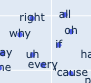

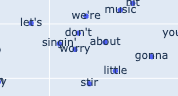

> A su vez observamos como la palabras mas cercana para "woman" es "cry" y la palabras mas cercana para "buffalo" es "soldier", lo cual es coherente con las liricas de las famosas canciones "buffalo soldier" y "no woman no cry" :)

> lo mismo sucede para "sherrif" con "shot", de "I shot the sheriff"

In [38]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["buffalo"], topn=5)

[('soldier', 0.8767678141593933),
 ('dreadlock', 0.8481713533401489),
 ('yoe', 0.8029671311378479),
 ('rasta', 0.7495781183242798),
 ('woe', 0.7286084890365601)]

In [37]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["woman"], topn=5)

[('cry', 0.7137670516967773),
 ('ism', 0.685452401638031),
 ('tears', 0.6797321438789368),
 ('fowl', 0.65244060754776),
 ('pyaka', 0.6459764838218689)]

In [36]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["sheriff"], topn=5)

[('shot', 0.8573581576347351),
 ('brown', 0.7240433692932129),
 ('fit', 0.6985981464385986),
 ('cap', 0.6791487336158752),
 ('mr', 0.6389192342758179)]

> Pequeña prueba con operaciones entre palabras que no parecen devolver ningun vector coherente por fuera del espacio de liricas de Bob Marley

In [43]:
one = w2v_model.wv.get_vector("buffalo")
two = w2v_model.wv.get_vector("soldier")

w2v_model.wv.most_similar(one+two)

[('soldier', 0.9691913723945618),
 ('buffalo', 0.9682090282440186),
 ('dreadlock', 0.8945441842079163),
 ('yoe', 0.8282148838043213),
 ('rasta', 0.7954780459403992),
 ('woe', 0.7524117827415466),
 ('blowing', 0.7329995632171631),
 ('yoy', 0.6614190936088562),
 ('air', 0.6512094736099243),
 ('wise', 0.643250048160553)]

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.